# **Heston Model Project**
Anita Mezzetti 

course: Machine Learning for finance

Table of context:
- [Explicit solution of the Heston price equation (functions)](#solution)
- [Stock paths generator (functions)](#stock)
- [Generate data](#data)
- [Monte Carlo simulation](#mc)
    - [Monte Carlo simulation with Antithetic variables](#mcav)
    - [Time analysis of Monte Cralo](#time_mc)
    - [Effects in changing number of simulations in Monte Carlo](#sim_mc)
    - [Error analysis Monte Carlo](#error_mc)
- [ML methods](#ml)
    - [Motivation in combining regression and classification](#moti)
    - [Classification](#classification)
    - [Regression](#regression)
- [Change Dataset: S0 fixed and K varying](#k)
- [Add other variables](#other_variable)


### Import packages

In [1]:
import numpy as np
import pandas as pd
import math as math
import cmath as cmath
from scipy import integrate
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from xgboost import XGBClassifier
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Explicit solution of the Heston price equation <a class="anchor" id="solution"></a>
In this section, we define the functions needed to find the numberical solution:
$$ C(S,T) = S P_1 - K P_2 $$
More details in the report

In [2]:
# characteristic function
def f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
    
    a = kappa * theta
    x = math.log(s0)
    
    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    d = cmath.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    
    C = r * phi * 1j * T + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * cmath.log((1 - g * cmath.exp(d * T))/(1 - g)))
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - cmath.exp(d * T)) / (1 - g * cmath.exp(d * T)))
    
    return cmath.exp(C + D * v0 + 1j * phi * x)

In [3]:
# P1 and P2
def p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    
    
    integrand = lambda phi: (cmath.exp(-1j * phi * cmath.log(K)) * f(phi, kappa, \
                              theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real 
    
    return (0.5 + (1 / math.pi) * integrate.quad(integrand, 0, 100)[0]) # approximate indefinite intergral with a definite one

def p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)

def p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)


In [4]:
# call price
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    
    P1 = p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    P2 = p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    
    result = (s0 * P1 - K * math.exp(-r * T) * P2)
    
    if result<0 or k-s0>1: # negative result or initial price very very low with respect to k
        result = 0
        
    return result

# Stock paths generator <a class="anchor" id="stock"></a>
We define the functions needed to create the stock paths using the Heston model dynamic:


In [7]:
# generate the stock price simulation
def stock_price_generator (T, n , m, r, S0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=False ):
    dt = T / n
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
    if entire_stock==False: # return only the stocks simulation at T
        result = s[:,-1]; 
    else:
        result = s; # return all the stock dynamic
        
    return result
    

In [8]:
# find the stock price from ST as expected return
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

# Generate Data <a class="anchor" id="data"></a>

- [all values fixed apart S0](#data1)
- [all values fixed apart K](#data2)
- [all values fixed apart S0 and r](#data3)
- [all values fixed apart S0 and V0](#data4)
- [all values fixed apart S0, T and V0](#data5)

In [9]:
generator = np.random.default_rng()

**- All values fixed apart S0**

In [10]:
# set parameters and constants
r = 0
k = 2
V0 = 0.01
sigma = 0.6
theta = 0.02
kappa = 6.21
T1 = 10
rho = -0.5

S0 = np.arange(0.5,4,0.01)

In [11]:
time_maturity = 3
num_simulations = 100
n = 250 # numbers of division of the time 

In [12]:
df1 = pd.read_csv('datasets/df1.csv')
df1 = df1.drop('Unnamed: 0', axis=1)

#df1 = pd.DataFrame(columns=['stock_zero', 'price'])

In [13]:
'''# fill the dataset
for s0 in S0:
    s = stock_price_generator (time_maturity, n, num_simulations, r, s0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=True)

    for stock_path in s: # for each simulation
        price = find_expected_payoff(stock_path, k, r, time_maturity)
        
        new_row = {
                      'price':price, 
                      'stock_zero':stock_path[T1],
                  }
        #append row to the dataframe
        df1 = df1.append(new_row, ignore_index=True)'''

"# fill the dataset\nfor s0 in S0:\n    s = stock_price_generator (time_maturity, n, num_simulations, r, s0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=True)\n\n    for stock_path in s: # for each simulation\n        price = find_expected_payoff(stock_path, k, r, time_maturity)\n        \n        new_row = {\n                      'price':price, \n                      'stock_zero':stock_path[T1],\n                  }\n        #append row to the dataframe\n        df1 = df1.append(new_row, ignore_index=True)"

In [14]:
df1.head()

,stock_zero,price
0,0.524303,0.0
1,0.522428,0.0
2,0.499181,0.0
3,0.494353,0.0
4,0.502161,0.0


In [15]:
len(df1)

70000

In [16]:
#df1.to_csv('datasets/df1.csv')

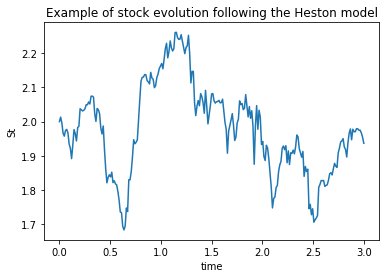

In [17]:
# plot one possible stock evolution as example example
stock_evolution = stock_price_generator (time_maturity, n, 1, r, 2, k, V0, sigma, theta, kappa, rho, generator, entire_stock=True)
stock_evolution = stock_evolution[0]
#plt.plot(stock_evolution)
x = np.linspace(0, time_maturity, num=n+1)

plt.plot(x, stock_evolution)
plt.title("Example of stock evolution following the Heston model")
plt.xlabel("time")
plt.ylabel("St")
plt.show()

# Monte Carlo simulation  <a class="anchor" id="mc"></a>

In [18]:
# function which finds the expected payoff 
def find_mc_price(sT, k, r, T):
    final = sT - k
    payoff = [max(x,0) for x in final] # one payoff for each simulation
    payoff = np.asarray(payoff)
    
    expected_payoff = payoff.mean() # mean
    
    c = expected_payoff * np.exp(-r * T)     # in case r=0, this step is useless
    
    return c

In [19]:
num_sim_mc = 1000

**- All values fixed apart S0**

In [20]:
df1_mc = pd.DataFrame(columns=['stock_zero', 'mc_price', 'num_price'])

In [21]:
df1_mc = pd.read_csv('datasets/df1_mc.csv')
df1_mc = df1_mc.drop('Unnamed: 0', axis=1)

In [22]:
'''# find the mc price
for s0 in S0:
    sT = stock_price_generator (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)

    mc = find_mc_price(sT, k, r, time_maturity)
    
    num_price = call_price(kappa, theta, sigma, rho, V0, r, time_maturity, s0, k)

    new_row = {
                  'mc_price':mc, 
                  'stock_zero':s0,
                  'num_price': num_price,
              }
    #append row to the dataframe
    df1_mc = df1_mc.append(new_row, ignore_index=True)'''

"# find the mc price\nfor s0 in S0:\n    sT = stock_price_generator (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)\n\n    mc = find_mc_price(sT, k, r, time_maturity)\n    \n    num_price = call_price(kappa, theta, sigma, rho, V0, r, time_maturity, s0, k)\n\n    new_row = {\n                  'mc_price':mc, \n                  'stock_zero':s0,\n                  'num_price': num_price,\n              }\n    #append row to the dataframe\n    df1_mc = df1_mc.append(new_row, ignore_index=True)"

In [23]:
df1_mc.head()

,stock_zero,mc_price,num_price,mc_price_av
0,0.50,0.0,0.0,0.0
1,0.51,0.0,0.0,0.0
2,0.52,0.0,0.0,0.0
3,0.53,0.0,0.0,0.0
4,0.54,0.0,0.0,0.0


In [22]:
len(df1_mc)

350

## Monte Carlo simulation with Antithetic variables <a class="anchor" id="mcav"></a>

In [23]:
def stock_price_generator_av (T, n ,m, r, S0, k, V0, sigma, theta, kappa, rho, separate=False):
    dt = T / n
    
    m = int(m/2) # with av we can do half of the simulations
    n = int(n)
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0
    
    s_ant = np.empty((m, n + 1))
    s_ant[:, 0] = S0

    v = np.ones(m) * V0
    v_ant = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        dv_ant = kappa * (theta - v_ant) * dt + sigma * np.sqrt(v_ant) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]
        ds_ant = r * s_ant[:, t] * dt + np.sqrt(v_ant) * s_ant[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        v_ant = np.clip(v_ant + dv_ant, a_min=0.0, a_max=None)
        
        s[:, t + 1] = s[:, t] + ds
        s_ant[:, t + 1] = s_ant[:, t] + ds_ant
        
    if separate==True:
        return s, s_ant
        
    return np.concatenate((s, s_ant))[:,-1]

In [24]:
mc_price_av = []

In [25]:
'''# find the mc price
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
    
    mc_price_av.append(mc_av)'''

'# find the mc price\nfor s0 in S0:\n    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)\n    mc_av = find_mc_price(ST_ant, k, r, time_maturity)\n    \n    mc_price_av.append(mc_av)'

In [26]:
#df1_mc['mc_price_av'] = mc_price_av

In [24]:
df1_mc.head()

,stock_zero,mc_price,num_price,mc_price_av
0,0.50,0.0,0.0,0.0
1,0.51,0.0,0.0,0.0
2,0.52,0.0,0.0,0.0
3,0.53,0.0,0.0,0.0
4,0.54,0.0,0.0,0.0


In [28]:
# df1_mc.to_csv('datasets/df1_mc.csv')

In [29]:
df1_mc = pd.read_csv('datasets/df1_mc.csv')
df1_mc = df1_mc.drop('Unnamed: 0', axis=1)
df1_mc.head()

,stock_zero,mc_price,num_price,mc_price_av
0,0.50,0.0,0.0,0.0
1,0.51,0.0,0.0,0.0
2,0.52,0.0,0.0,0.0
3,0.53,0.0,0.0,0.0
4,0.54,0.0,0.0,0.0


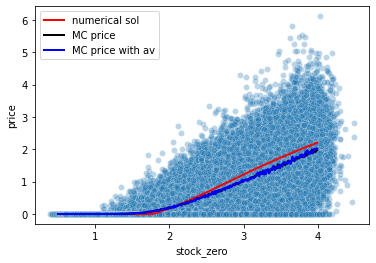

In [25]:
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, df1_mc. mc_price, color='black', linewidth=2, label='MC price')
plt.plot(S0, df1_mc. mc_price_av, color='blue', linewidth=2, label='MC price with av')
plt.legend()
plt.show()

The result with mc and mc_av are quite similar. let us know the difference in terms standard deviation and time needed to compute them 

### Time analysis for Monte Carlo  <a class="anchor" id="time_mc"></a>

In [31]:
start = time.time()
for s0 in S0:
    ST_ant = stock_price_generator (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
end = time.time()
time_cm = end - start
print(f"Time needed for Monte Carlo: {time_cm}")

Time needed for Monte Carlo: 14.529484510421753


In [32]:
start = time.time()
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
end = time.time()
time_cmav = end - start
print(f"Time needed for Monte Carlo with AV: {time_cmav}")

Time needed for Monte Carlo with AV: 13.313481569290161


In [33]:
perc_faster = (time_cm - time_cmav) / time_cm *100
perc_faster = round(perc_faster,2)
print(f"Monte Carlo with AV is {perc_faster}% faster tham the usual Monte Carlo")

Monte Carlo with AV is 8.37% faster tham the usual Monte Carlo


### Changes with different numbers of simulations <a class="anchor" id="sim_mc"></a>

In [34]:
num_sim_mc1 = 100
num_sim_mc2 = 5000

In [35]:
mc_price_av1 = []

# find the mc price
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc1, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
    
    mc_price_av1.append(mc_av)

In [36]:
mc_price_av2 = []

# find the mc price
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc2, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
    
    mc_price_av2.append(mc_av)

In [37]:
df1_mc['mc_price_av1'] = mc_price_av1
df1_mc['mc_price_av2'] = mc_price_av2

In [38]:
df1_mc.head()

,stock_zero,mc_price,num_price,mc_price_av,mc_price_av1,mc_price_av2
0,0.50,0.0,0.0,0.0,0.0,0.0
1,0.51,0.0,0.0,0.0,0.0,0.0
2,0.52,0.0,0.0,0.0,0.0,0.0
3,0.53,0.0,0.0,0.0,0.0,0.0
4,0.54,0.0,0.0,0.0,0.0,0.0


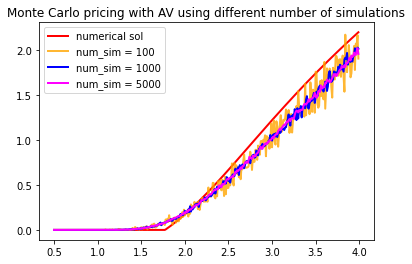

In [39]:
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, df1_mc. mc_price_av1, color='orange', linewidth=2, label='num_sim = 100', alpha=0.8)
plt.plot(S0, df1_mc. mc_price_av, color='blue', linewidth=2, label='num_sim = 1000')
plt.plot(S0, df1_mc. mc_price_av2, color='magenta', linewidth=2, label='num_sim = 5000')
plt.title("Monte Carlo pricing with AV using different number of simulations")
plt.legend()
plt.show()

The behaviour is similar for all the numbers of simulations

### Error Analysis MC  <a class="anchor" id="error_mc"></a>

In [59]:
def root_mean_square_error(num_sol, proposed_solution):
    n = len(num_sol) 
    difference = num_sol-proposed_solution
    square_diff = [x ** 2 for x in difference]
    error = np.sqrt((sum(square_diff)/n))
    return error

In [41]:
err_mc = root_mean_square_error(df1_mc.num_price, df1_mc.mc_price)
err_mc_av = root_mean_square_error(df1_mc.num_price, df1_mc.mc_price_av)
err_mc_av1 = root_mean_square_error(df1_mc.num_price, df1_mc.mc_price_av1)
err_mc_av2 = root_mean_square_error(df1_mc.num_price, df1_mc.mc_price_av2)

print(f"RMSQ Monte Carlo (num_simulations = {num_sim_mc}): {err_mc}")
print(f"RMSQ Monte Carlo with AV (num_simulations = {num_sim_mc1}): {err_mc_av1}")
print(f"RMSQ Monte Carlo with AV (num_simulations = {num_sim_mc}): {err_mc_av}")
print(f"RMSQ Monte Carlo with AV (num_simulations = {num_sim_mc2}): {err_mc_av2}")

RMSQ Monte Carlo (num_simulations = 1000): 0.14124623047806095
RMSQ Monte Carlo with AV (num_simulations = 100): 0.15393558463191884
RMSQ Monte Carlo with AV (num_simulations = 1000): 0.1383395065212146
RMSQ Monte Carlo with AV (num_simulations = 5000): 0.1369850303820998


# Machine Learning models <a class="anchor" id="ml"></a>

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.optimizers import Adam

In [27]:
df1.head()

,stock_zero,price
0,0.524303,0.0
1,0.522428,0.0
2,0.499181,0.0
3,0.494353,0.0
4,0.502161,0.0


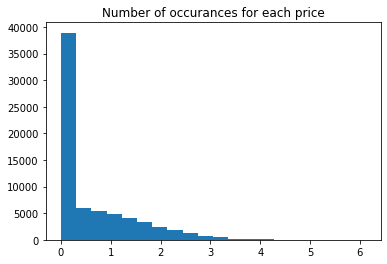

In [44]:
plt.hist(df1.price, bins =20)
plt.title("Number of occurances for each price")
plt.show()

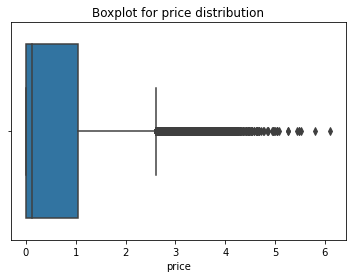

In [45]:
sns.boxplot(x=df1.price)
plt.title("Boxplot for price distribution")
plt.show()

### Motivation in combining regression and classification <a class="moti" id="lr"></a>

We start running the simple linear regression, then we add the logistic classification and we plot the differences in order to explain why this combination makes sense. Essentially, this section is an introduction which explain why we decide to combine regression and classification 

In [46]:
y = df1.price
X = df1.stock_zero

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
x_train = x_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [48]:
lin = LinearRegression()
lin.fit(x_train, y_train)
y_pred_lin = lin.predict(x_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Linear Regression RMSE: 0.5683109209938474


In [49]:
price_linear = lin.predict(S0.reshape(-1, 1))

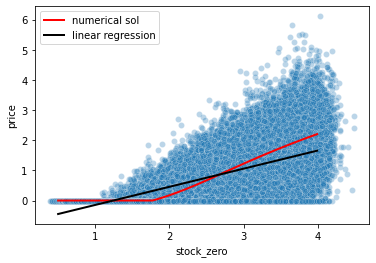

In [50]:
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, price_linear, color='black', linewidth=2, label='linear regression')
plt.legend()
plt.show()

In [51]:
df1_class = pd.DataFrame()
df1_class['exercise'] = df1.price!=0
df1_class['stock_zero'] = df1.stock_zero
df1_class.head()

,exercise,stock_zero
0,False,0.524303
1,False,0.522428
2,False,0.499181
3,False,0.494353
4,False,0.502161


In [52]:
X_class = df1_class['stock_zero']
y_class = df1_class['exercise']

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2)

In [53]:
x_train_class = x_train_class.values.reshape(-1, 1)
y_train_class = y_train_class.values.reshape(-1, 1)
x_test_class = x_test_class.values.reshape(-1, 1)

In [54]:
logreg = LogisticRegression()
logreg.fit(x_train_class, y_train_class)

LogisticRegression()

In [55]:
execute_log = logreg.predict(S0.reshape(-1, 1))

In [56]:
df1_ml = pd.DataFrame()

In [57]:
price_log_lin = []

for i in range(len(S0)):
    if execute_log[i]==0:
        price_log_lin.append(0)
    else:
        price_log_lin.append(price_linear[i])    

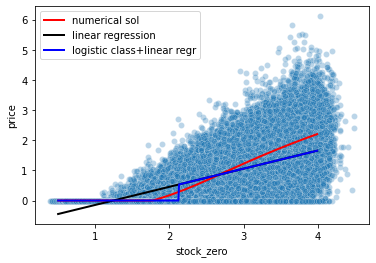

In [58]:
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, price_linear, color='black', linewidth=2, label='linear regression')
plt.plot(S0, price_log_lin, color='blue', linewidth=2, label='logistic class+linear regr')
plt.legend()
plt.show()

In [59]:
df1_class['price'] = df1.price

In [60]:
df1_class['exercise_predict'] = logreg.predict(df1_class['stock_zero'].values.reshape(-1, 1))

In [61]:
df1_class.head()

,exercise,stock_zero,price,exercise_predict
0,False,0.524303,0.0,False
1,False,0.522428,0.0,False
2,False,0.499181,0.0,False
3,False,0.494353,0.0,False
4,False,0.502161,0.0,False


In [62]:
# execute linear regression only on nonzero values (only if exercised)
# => liear regression only on cleaned data

df1_class_linear = df1_class.loc[ df1_class['exercise_predict']==True ]
df1_class_linear.head()

,exercise,stock_zero,price,exercise_predict
14188,True,2.124788,0.461163,True
14625,True,2.193899,0.474660,True
14734,False,2.129866,0.000000,True
14825,False,2.133750,0.000000,True
14860,False,2.126172,0.000000,True


In [63]:
y = df1_class_linear.price
X = df1_class_linear.stock_zero

x_train_lin_cleaned, x_test_lin_cleaned, y_train_lin_cleaned, y_test_lin_cleaned = train_test_split(X, y, test_size=0.2)

In [64]:
x_train_lin_cleaned = x_train_lin_cleaned.values.reshape(-1, 1)
y_train_lin_cleaned = y_train_lin_cleaned.values.reshape(-1, 1)
x_test_lin_cleaned = x_test_lin_cleaned.values.reshape(-1, 1)

In [65]:
lin_clean = LinearRegression()
lin_clean.fit(x_train_lin_cleaned, y_train_lin_cleaned)
y_pred_lin_cleaned = lin_clean.predict(x_test_lin_cleaned)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test_lin_cleaned, y_pred_lin_cleaned)))

Linear Regression RMSE: 0.6894927887652422


In [66]:
price_pred_lin_cleaned = lin_clean.predict(S0.reshape(-1, 1))

In [67]:
df1_ml = pd.DataFrame()

In [68]:
price_log_lin_cleaned = []

for i in range(len(S0)):
    if execute_log[i]==0:
        price_log_lin_cleaned.append(0)
    else:
        price_log_lin_cleaned.append(price_pred_lin_cleaned[i])    

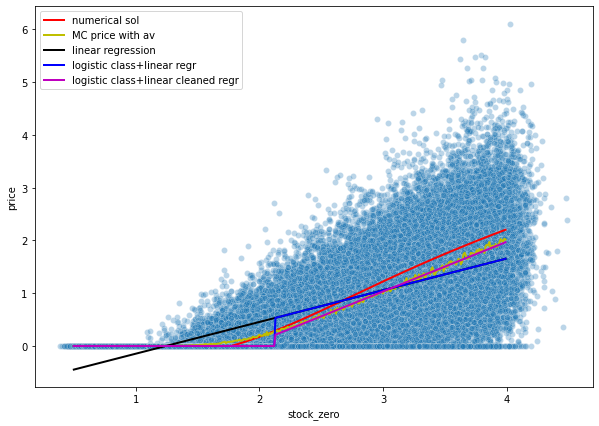

In [69]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, df1_mc. mc_price_av, color='y', linewidth=2, label='MC price with av')
plt.plot(S0, price_linear, color='black', linewidth=2, label='linear regression')
plt.plot(S0, price_log_lin, color='blue', linewidth=2, label='logistic class+linear regr')
plt.plot(S0, price_log_lin_cleaned, color='m', linewidth=2, label='logistic class+linear cleaned regr')
plt.legend()
plt.show()

## Classification methods <a class="anchor" id="classification"></a>

In [29]:
def plot_confusion_matrix (confusion_matrix, title):

    ax = plt.subplot()
    sns.heatmap(confusion_matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1, linecolor = "w", cmap = "Pastel2")
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.xaxis.set_ticklabels(['Exercised','Not Exercised'])
    ax.yaxis.set_ticklabels(['Exercised','Not Exercised'], va="center")
    plt.title(title)
    plt.show()

In [30]:
def plot_roc_curve(X_test, y_test, y_pred, model, title):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    titlee = 'Exercise ROC curve ' + title
    plt.title(titlee)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [31]:
df1_class = pd.DataFrame()
df1_class['exercise'] = df1.price!=0
df1_class['stock_zero'] = df1.stock_zero
df1_class['binary'] = [1 if x==True else 0 for x in df1_class['exercise']]
df1_class.head()

,exercise,stock_zero,binary
0,False,0.524303,0
1,False,0.522428,0
2,False,0.499181,0
3,False,0.494353,0
4,False,0.502161,0


In [32]:
X = df1_class['stock_zero']
y = df1_class['exercise']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [33]:
X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

### Logistic Regression

In [39]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
y_pred_logistic = logreg.predict(X_test)

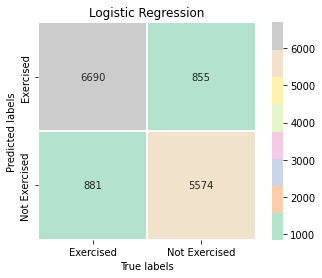

In [41]:
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_logistic, labels=[True, False])
plot_confusion_matrix (confusion_matrix_logistic, 'Logistic Regression')

In [42]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

       False       0.87      0.86      0.87      6455
        True       0.88      0.89      0.89      7545

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



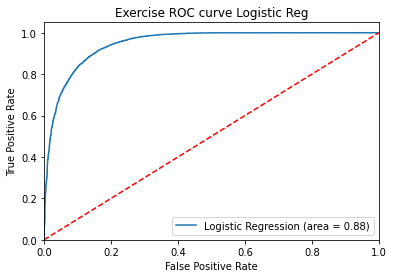

In [43]:
plot_roc_curve(X_test, y_test, y_pred_logistic, logreg, 'Logistic Reg')

### KNN

In [44]:
Neighbor_List=[3,5,10,20]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
classifier_knn = GridSearchCV(KNNC, parameters, cv=5, verbose=0, scoring ='accuracy')

classifier_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 10, 20]}, scoring='accuracy')

In [45]:
y_pred_knn = classifier_knn.predict(X_test)

In [46]:
print('Accuracy KNN: {:.2f}%'.format(logreg.score(X_test, y_test)*100))

Accuracy KNN: 87.60%


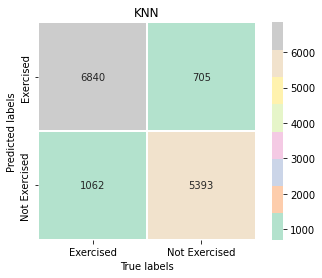

In [47]:
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn, labels=[True, False])
plot_confusion_matrix (confusion_matrix_knn, 'KNN')

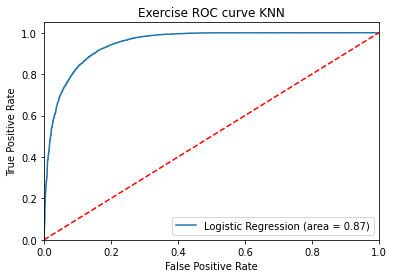

In [48]:
plot_roc_curve(X_test, y_test, y_pred_knn, classifier_knn, 'KNN')

In [49]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.88      0.84      0.86      6455
        True       0.87      0.91      0.89      7545

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



### XGBoost Classifier

In [50]:
'''params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.8]
}'''

params = {
    'n_estimators': [100],
    'max_depth': [2],
    'learning_rate': [0.005],
    'subsample': [0.4]
}
classifier_xgboost = GridSearchCV(XGBClassifier(random_state=10), params, scoring ='accuracy')
classifier_xgboost.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=10,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=

In [51]:
y_pred_xgboost = classifier_xgboost.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

       False       0.91      0.82      0.86      6455
        True       0.86      0.93      0.89      7545

    accuracy                           0.88     14000
   macro avg       0.88      0.87      0.88     14000
weighted avg       0.88      0.88      0.88     14000



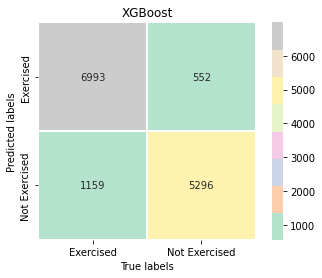

In [53]:
confusion_matrix_knn = confusion_matrix(y_test, y_pred_xgboost, labels=[True, False])
plot_confusion_matrix (confusion_matrix_knn, 'XGBoost')

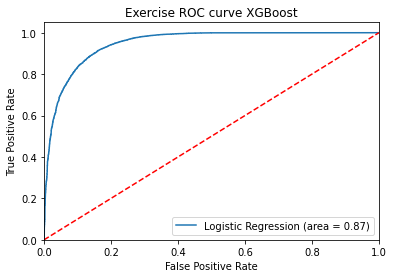

In [54]:
plot_roc_curve(X_test, y_test, y_pred_xgboost, classifier_xgboost, 'XGBoost')

### Neural Network

In [91]:
def print_accuracy(train_metric, val_metric):
    # summarize history for loss
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.plot([0, len(train_metric)], [0.5, 0.5], '--', color='black', alpha=0.7)
    plt.title('Model AUC progress')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ymax = 1, ymin = 0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [92]:
epoch_num = 30

In [93]:
# 1 hidden layer
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=1e-2),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(), AUC(), Precision(), Recall()])

In [94]:
history = model.fit(X, y, epochs=epoch_num, validation_split=0.2, batch_size=128, callbacks=[History()])

Epoch 1/30
438/438 [==============================] - 1s 3ms/step - loss: 0.3328 - binary_accuracy: 0.8508 - auc: 0.9329 - precision: 0.8212 - recall: 0.8384 - val_loss: 0.2232 - val_binary_accuracy: 0.9379 - val_auc: 0.7120 - val_precision: 0.9380 - val_recall: 0.9999
Epoch 2/30
438/438 [==============================] - 1s 2ms/step - loss: 0.3033 - binary_accuracy: 0.8620 - auc: 0.9424 - precision: 0.8347 - recall: 0.8500 - val_loss: 0.2167 - val_binary_accuracy: 0.9380 - val_auc: 0.7117 - val_precision: 0.9380 - val_recall: 1.0000
Epoch 3/30
438/438 [==============================] - 1s 2ms/step - loss: 0.2978 - binary_accuracy: 0.8637 - auc: 0.9427 - precision: 0.8233 - recall: 0.8732 - val_loss: 0.2159 - val_binary_accuracy: 0.9380 - val_auc: 0.7111 - val_precision: 0.9380 - val_recall: 1.0000
Epoch 4/30
438/438 [==============================] - 1s 2ms/step - loss: 0.2973 - binary_accuracy: 0.8647 - auc: 0.9426 - precision: 0.8256 - recall: 0.8723 - val_loss: 0.2163 - val_binary_

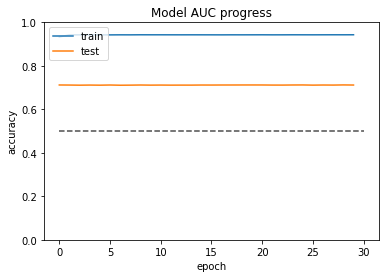

In [95]:
print_accuracy( history.history['auc'], history.history['val_auc'])

In [96]:
# 1 wider hidden layer
wider_model = Sequential()
wider_model.add(Dense(20, input_dim=1, activation='relu'))
wider_model.add(Dense(40, activation='relu'))
wider_model.add(Dense(1, activation='sigmoid'))

wider_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(), AUC(), Precision(), Recall()])

In [97]:
history_wider = wider_model.fit(X, y, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
438/438 [==============================] - 2s 4ms/step - loss: 0.4150 - binary_accuracy: 0.8175 - auc_1: 0.9132 - precision_1: 0.7465 - recall_1: 0.8767 - val_loss: 0.2226 - val_binary_accuracy: 0.9380 - val_auc_1: 0.7109 - val_precision_1: 0.9380 - val_recall_1: 1.0000
Epoch 2/30
438/438 [==============================] - 1s 2ms/step - loss: 0.3022 - binary_accuracy: 0.8637 - auc_1: 0.9430 - precision_1: 0.8328 - recall_1: 0.8581 - val_loss: 0.2176 - val_binary_accuracy: 0.9380 - val_auc_1: 0.7121 - val_precision_1: 0.9380 - val_recall_1: 1.0000
Epoch 3/30
438/438 [==============================] - 1s 2ms/step - loss: 0.2980 - binary_accuracy: 0.8648 - auc_1: 0.9432 - precision_1: 0.8255 - recall_1: 0.8726 - val_loss: 0.2164 - val_binary_accuracy: 0.9380 - val_auc_1: 0.7122 - val_precision_1: 0.9380 - val_recall_1: 1.0000
Epoch 4/30
438/438 [==============================] - 1s 2ms/step - loss: 0.2968 - binary_accuracy: 0.8645 - auc_1: 0.9432 - precision_1: 0.8213 - recall_

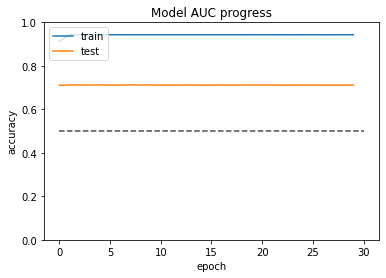

In [98]:
print_accuracy(history_wider.history['auc_1'], history_wider.history['val_auc_1'])

As you can see, it overfits!!!!! No good method (we leave it only to point out that we have tried but we cannot use a method that overfeats)

### Error Classification

In [117]:
# we get s0 and the numerical solution from the mc dataset
df1_class_s0 = pd.DataFrame()
df1_class_s0 = df1_mc[['stock_zero', 'num_price']]
df1_class_s0['real_exercise'] =  [False if x==0.0 else True for x in df1_class_s0.num_price]
df1_class_s0 = df1_class_s0.drop('num_price', axis=1)

In [118]:
df1_class_s0['log_regre'] = logreg.predict(df1_class_s0['stock_zero'].values.reshape(-1, 1))
df1_class_s0['knn'] = classifier_knn.predict(df1_class_s0['stock_zero'].values.reshape(-1, 1))
df1_class_s0['xg_boost'] = classifier_xgboost.predict(df1_class_s0['stock_zero'].values.reshape(-1, 1))
df1_class_s0.head()

,stock_zero,real_exercise,log_regre,knn,xg_boost
0,0.50,False,False,False,False
1,0.51,False,False,False,False
2,0.52,False,False,False,False
3,0.53,False,False,False,False
4,0.54,False,False,False,False


In [119]:
# from False/True to 0/1 
df1_class_s0 = df1_class_s0.astype(int)
df1_class_s0.head()

,stock_zero,real_exercise,log_regre,knn,xg_boost
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [120]:
error_classification = {}
for column in ['log_regre', 'knn', 'xg_boost']:
    error_classification[column] = root_mean_square_error(df1_class_s0['real_exercise'], df1_class_s0[column])

In [121]:
error_classification

{'log_regre': 0.31622776601683794,
 'knn': 0.282842712474619,
 'xg_boost': 0.23904572186687872}

### Plot classification results

In [122]:
def plot_classification_points(x, binary, title):
    fig, ax = plt.subplots(figsize=(25,2))
    ax.plot_date(x, binary, fmt='b*', alpha=0.01)
    plt.title(title)
    plt.show()

## Regression methods <a class="anchor" id="regression"></a>

First create the dataset for the regression and prepare data

In [123]:
df1['pred_executed_logistic'] = logreg.predict(df1['stock_zero'].values.reshape(-1, 1))
df1.head()

,stock_zero,price,pred_executed_logistic
0,0.524303,0.0,False
1,0.522428,0.0,False
2,0.499181,0.0,False
3,0.494353,0.0,False
4,0.502161,0.0,False


In [124]:
df1_regr = df1[df1['pred_executed_logistic']==True]
df1_regr = df1_regr.drop('pred_executed_logistic', axis=1)
df1_regr.head()

,stock_zero,price
14188,2.124788,0.461163
14625,2.193899,0.474660
14734,2.129866,0.000000
14825,2.133750,0.000000
14860,2.126172,0.000000


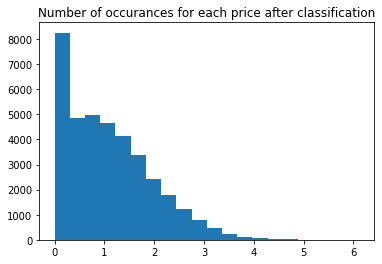

In [125]:
plt.hist(df1_regr.price, bins =20)
plt.title("Number of occurances for each price after classification")
plt.show()

In [126]:
X = df1_regr['stock_zero']
y = df1_regr['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [127]:
X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

### Linear Regression

In [128]:
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

### Ridge Regression

In [129]:
parameters = {'alpha': np.arange(0.001, 0.01, 0.1)}
ridge = Ridge()
ridge_best = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

### Decision Tree

In [130]:
'''DTSplitList=[0.001,0.05,0.1, 0.99]
DTLeafList=[0.005, 0.1,0.5]
criterion =['mse']
max_depth = list(range(30,0,-2))'''

DTSplitList=[0.1, 0.99]
DTLeafList=[0.1,0.5]
criterion =['mse']
max_depth = list(range(10,0,-5))

parameters = {'criterion':criterion,'max_depth':max_depth, 'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
dec_tree = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')

dec_tree.fit(X_train, y_train)
y_pred_dec = dec_tree.predict(X_test)

In [131]:
print("DTR best parameters:", dec_tree.best_params_)

DTR best parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


### Random Forest

In [132]:
'''RFEstimatorList = [25,50,100,200]
criterion =['mse']
max_depth = list(range(20,0,-2))'''

RFEstimatorList = [50]
criterion =['mse']
max_depth = list(range(10,0,-5))

parameters = {'criterion':criterion,'max_depth':max_depth,'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
RFR_best = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
RFR_best.fit(X_train, y_train)

y_pred_random = RFR_best.predict(X_test)

In [133]:
print("RFR best parameters:", RFR_best.best_params_)

RFR best parameters: {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 50}


### XGBoost Regression

In [134]:
params = {
    'n_estimators': [200],
    'max_depth': [2],
    'learning_rate': [0.01],
    'subsample': [0.4],
    'objective' :['reg:squarederror']
}

'''params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.6, 0.8],
    'objective' :['reg:squarederror']
    
}'''
xgb_regress = GridSearchCV(XGBRegressor(silent=False,random_state=10), params, scoring ='neg_mean_squared_error')
xgb_regress.fit(X_train, y_train)
y_pred_xgb_regress = xgb_regress.predict(X_test)

print("XGBR best parameters:", xgb_regress.best_params_)

[19:29:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:29:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:29:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

print("Linear SMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("Decision Tree SMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dec)))
print("Random Forest SMSE:", np.sqrt(mean_squared_error(y_test, y_pred_random)))
print("XGBoost SMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb_regress)))

### Neural Networks

In [117]:
def print_accuracy(train_metric, val_metric):
    # summarize history for loss
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.plot([0, len(train_metric)], [0.5, 0.5], '--', color='black', alpha=0.7)
    plt.title('Model AUC progress')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ymax = 1, ymin = 0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [118]:
X = df1_regr['stock_zero']
y = df1_regr['price']

epoch_num = 30

In [119]:
# 1 hidden layer
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-2),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [120]:
history = model.fit(X, y, epochs=epoch_num, validation_split=0.2, batch_size=128, callbacks=[History()])

Epoch 1/30
235/235 [==============================] - 1s 2ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24.8864 - val_root_mean_squared_error: 2.3198
Epoch 2/30
235/235 [==============================] - 0s 1ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24.8864 - val_root_mean_squared_error: 2.3198
Epoch 3/30
235/235 [==============================] - 0s 1ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24.8864 - val_root_mean_squared_error: 2.3198
Epoch 4/30
235/235 [==============================] - 0s 1ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24.8864 - val_root_mean_squared_error: 2.3198
Epoch 5/30
235/235 [==============================] - 0s 1ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24.8864 - val_root_mean_squared_error: 2.3198
Epoch 6/30
235/235 [==============================] - 0s 1ms/step - loss: 14.7378 - root_mean_squared_error: 1.6231 - val_loss: 24

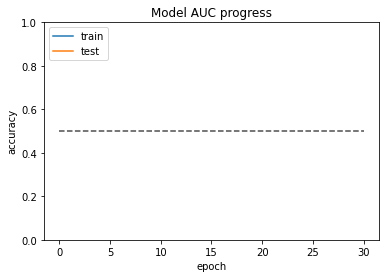

In [121]:
print_accuracy( history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error'])

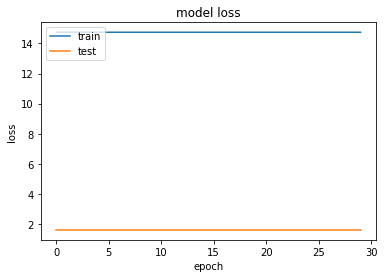

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Analyse errors

In [123]:
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Decision RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dec)))
print("Random RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_random)))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb_regress)))

Linear RMSE: 0.6838483687066708
Ridge RMSE: 0.6838483687762152
Decision RMSE: 0.6846440776614879
Random RMSE: 0.6838417391159536
XGBoost RMSE: 0.6931194326918351


### Use different Regression methods with S0

In [135]:
df1_regre = pd.DataFrame(columns=['stock_zero'])

In [136]:
lin_s0 = lin.predict(S0.reshape(-1, 1))
ridge_best_s0 = ridge_best.predict(S0.reshape(-1, 1))
dec_tree_s0 = dec_tree.predict(S0.reshape(-1, 1))
RFR_best_s0 = RFR_best.predict(S0.reshape(-1, 1))
xgb_regress_s0 = xgb_regress.predict(S0.reshape(-1, 1))

In [137]:
# classification
S0_class = logreg.predict(S0.reshape(-1, 1))

In [138]:
'''df1_regre['stock_zero'] = S0
df1_regre['linear_best_s0'] = ridge_best_s0
df1_regre['ridge_best_s0'] = ridge_best_s0
df1_regre['dec_tree_s0'] = dec_tree_s0
df1_regre['RFR_best_s0'] = RFR_best_s0
df1_regre['xgb_regress_s0'] = xgb_regress_s0'''

In [140]:
for i in range(len(S0_class)): 
    if S0_class[i]==False:
        df1_regre.iloc[i] = (S0[i], 0, 0, 0, 0, 0)        

In [141]:
df1_regre.head()

,stock_zero,linear_best_s0,ridge_best_s0,dec_tree_s0,RFR_best_s0,xgb_regress_s0
0,0.50,0.0,0.0,0.0,0.0,0.0
1,0.51,0.0,0.0,0.0,0.0,0.0
2,0.52,0.0,0.0,0.0,0.0,0.0
3,0.53,0.0,0.0,0.0,0.0,0.0
4,0.54,0.0,0.0,0.0,0.0,0.0


In [142]:
#df1_regre.to_csv('datasets/df1_regre.csv')

In [143]:
df1_regre = pd.read_csv('datasets/df1_regre.csv')

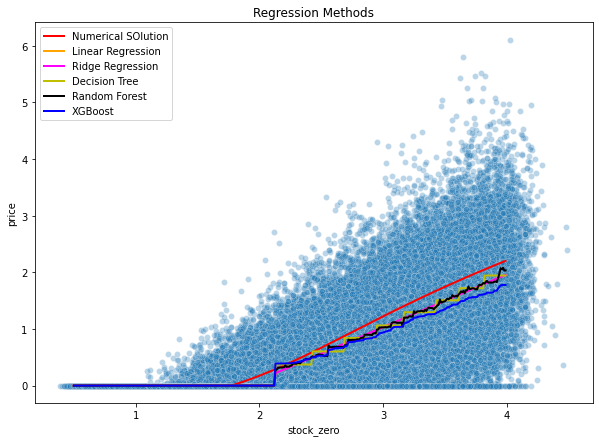

In [144]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='Numerical SOlution')
plt.plot(S0, df1_regre.linear_best_s0, color='orange', linewidth=2, label='Linear Regression')
plt.plot(S0, df1_regre.ridge_best_s0, color='magenta', linewidth=2, label='Ridge Regression')
plt.plot(S0, df1_regre.dec_tree_s0, color='y', linewidth=2, label='Decision Tree')
plt.plot(S0, df1_regre.RFR_best_s0, color='black', linewidth=2, label='Random Forest')
plt.plot(S0, df1_regre.xgb_regress_s0, color='blue', linewidth=2, label='XGBoost')
plt.title("Regression Methods")
plt.legend()
plt.show()

## Area Around Step

First we check where is the classification step. W

In [159]:
df1_ordered = df1.sort_values(by=['stock_zero']).reset_index(drop=True)
df1_ordered.head()

,stock_zero,price,pred_executed_logistic
0,0.387751,0.0,False
1,0.407598,0.0,False
2,0.419984,0.0,False
3,0.422262,0.0,False
4,0.426654,0.0,False


In [160]:
S0_class = logreg.predict(S0.reshape(-1, 1))
X_class = df1_ordered['pred_executed_logistic']
#X_class = logreg.predict(df1_ordered['stock_zero'].values.reshape(-1, 1))

X:

In [161]:
X_len = len(X_class)
area_size_step = int(X_len/10) # 5%
area_size_step

7000

In [162]:
where_changes = [i for i in range(1,X_len) if X_class[i]!=X_class[i-1] ]
step_position = int(np.mean(where_changes))
step_position

32525

In [163]:
# where begin regression
begin_regression_pos = step_position - area_size_step
begin_regression_pos

25525

In [164]:
df1_regr_with_area = df1_ordered.loc[begin_regression_pos:]
df1_regr_with_area.head()

,stock_zero,price,pred_executed_logistic
25525,1.768221,0.171459,False
25526,1.768247,0.432914,False
25527,1.768251,0.000000,False
25528,1.768261,0.323148,False
25529,1.768296,0.000000,False


In [165]:
X_area = df1_regr_with_area['stock_zero']
y_area = df1_regr_with_area['price']

X_train_area, X_test_area, y_train_area, y_test_area = train_test_split(X_area, y_area, test_size=0.20)

In [166]:
X_train_area = X_train_area.values.reshape(-1, 1)
y_train_area = y_train_area.values.reshape(-1, 1)
X_test_area = X_test_area.values.reshape(-1, 1)

In [167]:
lin_area = LinearRegression()
lin_area.fit(X_train_area, y_train_area)
y_pred_lin_area = lin_area.predict(X_test_area)

S0:

In [168]:
S0_len = len(S0)
area_size_step_S0 = int(S0_len/10) # 5%

In [169]:
where_changes_S0 = [i for i in range(1,len(S0)) if S0_class[i]!=S0_class[i-1] ]
step_position_S0 = int(np.mean(where_changes_S0))
step_position_S0

163

In [170]:
# where begin regression
begin_regression_pos_S0 = step_position_S0 - area_size_step_S0
begin_regression_pos_S0

128

In [171]:
lin_s0_area_regr = lin_area.predict(S0[begin_regression_pos_S0:].reshape(-1, 1))
lin_s0_with_area = np.concatenate((np.zeros(begin_regression_pos_S0), lin_s0_area_regr.flatten()))

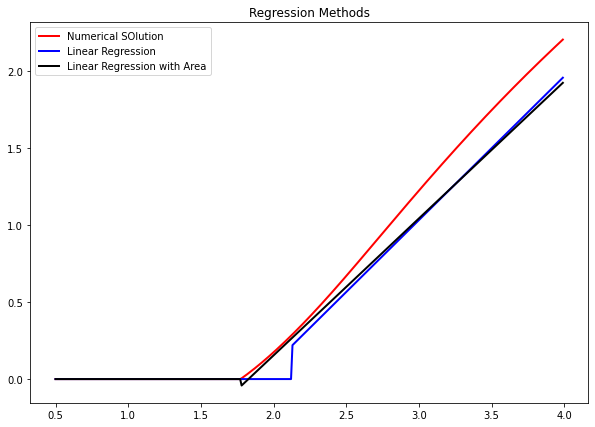

In [172]:
plt.figure(figsize=(10,7))
#sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='Numerical SOlution')
plt.plot(S0, df1_regre.linear_best_s0, color='blue', linewidth=2, label='Linear Regression')
plt.plot(S0, lin_s0_with_area, color='black', linewidth=2, label='Linear Regression with Area')
plt.title("Regression Methods")
plt.legend()
plt.show()

In [144]:
# regression only in the area